In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Jan 24 22:07:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   31C    P8    23W / 250W |   1107MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import ThreeFeature_All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import ThreeFeature_All_CNN6Layer_A1 as ModelA1
from model.models_mjp_19November20 import ThreeFeature_All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import ThreeFeature_All_CNN8Layer_W as ModelW
from model.models_mjp_26December20 import ThreeFeature_All_CNN10Layer_X as ModelX
from model.models_mjp_26December20 import ThreeFeature_All_CNN8Layer_Y as ModelY

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

# imports needed for BaseTrainer class
import pytorch_lightning as pl

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 50, 5e-5, 3420)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
## 
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          #device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 26.51 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 26.09 s
Constructing 160000 event dataset took 2.209 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 5.118 s
Constructing 9984 event dataset took 0.1156 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelY()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=9.0)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/6e49222f5c5a405ba2f753b4fe77a835/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=False)

we also froze 0 weights
Of the 33.0 parameter layers to update in the current model, 33.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ThreeFeature_All_CNN8Layer_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (largeConv): Conv1d(2, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


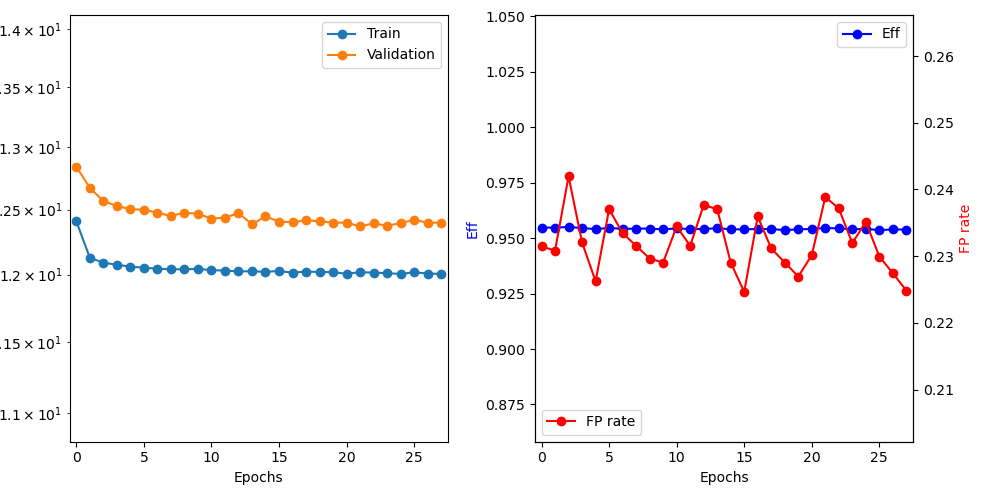

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
avgEff=0
avgFP=0
print('for model: ', model)   
run_name = 'Model Y (PA)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '9.0')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  ThreeFeature_All_CNN8Layer_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (largeConv): Conv1d(2, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 3420: train=12.4079, val=12.8414, took 179.81 s
  Validation Found 52036 of 54504, added 2311 (eff 95.47%) (0.231 FP/event)
Result epoch:  3420
Average Eff:  0
Average FP Rate:  0


Epoch 3421: train=12.1276, val=12.6709, took 174.11 s
  Validation Found 52034 of 54504, added 2305 (eff 95.47%) (0.231 FP/event)
Result epoch:  3421
Average Eff:  0
Average FP Rate:  0


Epoch 3422: train=12.0898, val=12.5683, took 173.57 s
  Validation Found 52051 of 54504, added 2416 (eff 95.50%) (0.242 FP/event)
Result epoch:  3422
Average Eff:  0
Average FP Rate:  0


Epoch 3423: train=12.0748, val=12.5279, took 173.3 s
  Validation Found 52024 of 54504, added 2317 (eff 95.45%) (0.232 FP/event)
Result epoch:  3423
Average Eff:  0
Average FP Rate:  0


Epoch 3424: train=12.0592, val=12.504, took 173.46 s
  Validation Found 51999 of 54504, added 2259 (eff 95.40%) (0.226 FP/event)
Result epoch:  3424
Average Eff:  0
Average FP Rate:  0


Epoch 3425: train=12.0527, val=12.4985, took 172.47 s
  Validation Found 52027 of 54504, added 2367 (eff 95.46%) (0.237 FP/event)
Result epoch:  3425
Average Eff:  0
Average FP Rate:  0


Epoch 3426: train=12.0436, val=12.4767, took 172.4 s
  Validation Found 52004 of 54504, added 2331 (eff 95.41%) (0.233 FP/event)
Result epoch:  3426
Average Eff:  0
Average FP Rate:  0


Epoch 3427: train=12.0409, val=12.4492, took 172.52 s
  Validation Found 52009 of 54504, added 2312 (eff 95.42%) (0.232 FP/event)
Result epoch:  3427
Average Eff:  0
Average FP Rate:  0


Epoch 3428: train=12.0394, val=12.4768, took 351.95 s
  Validation Found 52012 of 54504, added 2293 (eff 95.43%) (0.23 FP/event)
Result epoch:  3428
Average Eff:  0
Average FP Rate:  0


Epoch 3429: train=12.0442, val=12.4671, took 370.27 s
  Validation Found 51989 of 54504, added 2287 (eff 95.39%) (0.229 FP/event)
Result epoch:  3429
Average Eff:  0
Average FP Rate:  0


Epoch 3430: train=12.0335, val=12.4299, took 369.4 s
  Validation Found 52017 of 54504, added 2341 (eff 95.44%) (0.234 FP/event)
Result epoch:  3430
Average Eff:  0
Average FP Rate:  0


Epoch 3431: train=12.0305, val=12.4374, took 367.88 s
  Validation Found 52000 of 54504, added 2312 (eff 95.41%) (0.232 FP/event)
Result epoch:  3431
Average Eff:  0
Average FP Rate:  0


Epoch 3432: train=12.0244, val=12.4726, took 371.11 s
  Validation Found 52000 of 54504, added 2373 (eff 95.41%) (0.238 FP/event)
Result epoch:  3432
Average Eff:  0
Average FP Rate:  0


Epoch 3433: train=12.0247, val=12.3854, took 370.69 s
  Validation Found 52021 of 54504, added 2367 (eff 95.44%) (0.237 FP/event)
Result epoch:  3433
Average Eff:  0
Average FP Rate:  0


Epoch 3434: train=12.0211, val=12.4463, took 370.92 s
  Validation Found 51994 of 54504, added 2287 (eff 95.39%) (0.229 FP/event)
Result epoch:  3434
Average Eff:  0
Average FP Rate:  0


Epoch 3435: train=12.027, val=12.4069, took 369.95 s
  Validation Found 51991 of 54504, added 2243 (eff 95.39%) (0.225 FP/event)
Result epoch:  3435
Average Eff:  0
Average FP Rate:  0


Epoch 3436: train=12.0145, val=12.4002, took 370.22 s
  Validation Found 52002 of 54504, added 2356 (eff 95.41%) (0.236 FP/event)
Result epoch:  3436
Average Eff:  0
Average FP Rate:  0


Epoch 3437: train=12.0229, val=12.4173, took 370.22 s
  Validation Found 51999 of 54504, added 2308 (eff 95.40%) (0.231 FP/event)
Result epoch:  3437
Average Eff:  0
Average FP Rate:  0


Epoch 3438: train=12.0195, val=12.4081, took 368.21 s
  Validation Found 51975 of 54504, added 2287 (eff 95.36%) (0.229 FP/event)
Result epoch:  3438
Average Eff:  0
Average FP Rate:  0


Epoch 3439: train=12.018, val=12.3978, took 371.84 s
  Validation Found 51992 of 54504, added 2266 (eff 95.39%) (0.227 FP/event)
Result epoch:  3439
Average Eff:  0
Average FP Rate:  0


Epoch 3440: train=12.006, val=12.3986, took 371.65 s
  Validation Found 52002 of 54504, added 2298 (eff 95.41%) (0.23 FP/event)
Result epoch:  3440
Average Eff:  0
Average FP Rate:  0


Epoch 3441: train=12.0185, val=12.3685, took 370.49 s
  Validation Found 52025 of 54504, added 2385 (eff 95.45%) (0.239 FP/event)
Result epoch:  3441
Average Eff:  0
Average FP Rate:  0


Epoch 3442: train=12.0143, val=12.3923, took 369.11 s
  Validation Found 52016 of 54504, added 2368 (eff 95.44%) (0.237 FP/event)
Result epoch:  3442
Average Eff:  0
Average FP Rate:  0


Epoch 3443: train=12.011, val=12.3741, took 370.5 s
  Validation Found 51993 of 54504, added 2316 (eff 95.39%) (0.232 FP/event)
Result epoch:  3443
Average Eff:  0
Average FP Rate:  0


Epoch 3444: train=12.0044, val=12.3944, took 370.35 s
  Validation Found 52004 of 54504, added 2348 (eff 95.41%) (0.235 FP/event)
Result epoch:  3444
Average Eff:  0
Average FP Rate:  0


Epoch 3445: train=12.0177, val=12.4207, took 369.68 s
  Validation Found 51974 of 54504, added 2296 (eff 95.36%) (0.23 FP/event)
Result epoch:  3445
Average Eff:  0
Average FP Rate:  0


Epoch 3446: train=12.0077, val=12.3972, took 371.65 s
  Validation Found 51989 of 54504, added 2271 (eff 95.39%) (0.227 FP/event)
Result epoch:  3446
Average Eff:  0
Average FP Rate:  0


Epoch 3447: train=12.0052, val=12.3983, took 371.54 s
  Validation Found 51988 of 54504, added 2245 (eff 95.38%) (0.225 FP/event)
Result epoch:  3447
Average Eff:  0
Average FP Rate:  0


In [ ]:
##quit()